# A look at solutions to the proposed objective

In [1]:
## External modules.
import matplotlib.pyplot as plt
import numpy as np
from os import path
from scipy.optimize import minimize

## Internal modules.
from mml.utils import makedir_safe
from setup_dispersions import dispersion_huber
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend

In [2]:
## Create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Set up random generator.
entropy_common = 58238972897892348023984098239408290222
ss_common = np.random.SeedSequence(entropy_common)
rg_common = np.random.default_rng(seed=ss_common)

In [4]:
## Define the objective function (general form).
def bddmv_obj(a, b, x, alpha=0.9, beta=0.9, lam=1.0):
    out = np.zeros(shape=a.shape)
    for i in range(len(x)):
        out += dispersion_huber(x=(x[i]-a)/b)
    out *= lam * b / len(x)
    out += alpha * a + beta * b
    return out

In [5]:
## Generate some random data.
n = 25
data_name = "standard_gamma"

def get_data(data_name):
    if data_name == "standard_normal":
        return rg_common.normal(loc=0.0, scale=1.0, size=n)
    elif data_name == "standard_gamma":
        return rg_common.standard_gamma(2.2, size=n)
    elif data_name == "modified_normal":
        return rg_common.normal(loc=25.0, scale=5.0, size=n)
    elif data_name == "modified_gamma":
        return rg_common.standard_gamma(2.2, size=n)*5.0 + 25.0
    else:
        raise ValueError("Please provide a proper data name.")

x_data = get_data(data_name=data_name)


In [6]:
## Prepare the data-dependent objective functions.
mjh_lam = 1.0
mjh_beta = 0.5 / np.sqrt(len(x_data))
mjh_alpha = mjh_beta
def obj(a, b):
    ## For matplotlib contour visualization.
    return bddmv_obj(a, b, x=x_data, alpha=mjh_alpha, beta=mjh_beta, lam=mjh_lam)
def obj_tomin(u):
    ## For matplotlib contour visualization.
    return bddmv_obj(a=u[0], b=u[1], x=x_data, alpha=mjh_alpha, beta=mjh_beta, lam=mjh_lam)

In [7]:
## Define range to check (a,b) on, as well as initial value for solver.

if data_name in ["standard_normal", "standard_gamma"]:
    u0 = np.array([1.0, 0.05])
    a_min = -5
    a_max = 5
    b_min = 0.0001
    b_max = 5
elif data_name in ["modified_normal", "modified_gamma"]:
    u0 = np.array([1.0, 0.05])
    a_min = -50
    a_max = 50
    b_min = 0.0001
    b_max = 25
else:
    raise ValueError("Please provide a proper data name.")
    
a_range = np.linspace(a_min, a_max, 5000)
b_range = np.linspace(b_min, b_max, 5000)

In [8]:
## Try using SciPy solvers as extra evidence.

res = minimize(obj_tomin, u0, method="nelder-mead",
               options={"xatol": 1e-8, "disp": True})
print(res)
u_star = res.x

Optimization terminated successfully.
         Current function value: 0.715314
         Iterations: 82
         Function evaluations: 160
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.7153137118888453
             x: [ 1.733e+00  2.087e+00]
           nit: 82
          nfev: 160
 final_simplex: (array([[ 1.733e+00,  2.087e+00],
                       [ 1.733e+00,  2.087e+00],
                       [ 1.733e+00,  2.087e+00]]), array([ 7.153e-01,  7.153e-01,  7.153e-01]))


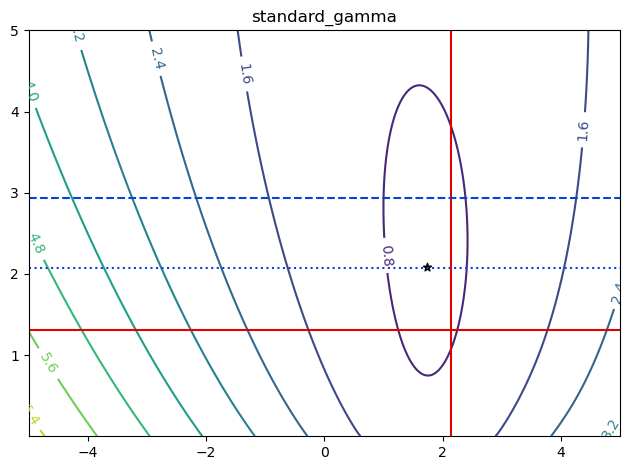

In [9]:
## Visualize key elements.
fig, ax = plt.subplots()

## Countours of the objective.
A, B = np.meshgrid(a_range, b_range)
C = obj(a=A, b=B)
CS = ax.contour(A, B, C)
ax.clabel(CS, inline=True, fontsize=10)

## Sample mean and standard deviation.
plt.axvline(x=np.mean(x_data), color="xkcd:red")
plt.axhline(y=np.std(x_data), color="xkcd:red")
plt.axhline(y=np.sqrt(mjh_lam/(2*mjh_beta))*np.std(x_data), color="xkcd:blue", linestyle="dashed")
plt.axhline(y=np.sqrt(mjh_lam/(4*mjh_beta))*np.std(x_data), color="xkcd:blue", linestyle="dotted")
ax.set_title(data_name)
ax.scatter(u_star[0], u_star[1], color="black", marker="*")
fname = path.join(img_dir, "soltest_{}.{}".format(data_name, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

___